In [1]:
import torch
import torch.cuda
import numpy as np

In [2]:
# setting device on GPU if available, else CPU
device =  torch.device('cpu') 
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



In [3]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import random
#seed_everything(random.randint(1, 10000))

In [4]:
import torchtext.datasets

train_iter, test_iter  = torchtext.datasets.AG_NEWS()

In [5]:
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def build_vocabulary(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary([train_iter]), min_freq=3, specials=["<UNK>"])
#vocab = build_vocab_from_iterator(build_vocabulary([train_iter, test_iter]), min_freq=10, specials=["<UNK>"])

vocab.set_default_index(vocab["<UNK>"])
len(vocab)

40708

In [6]:
def save_vocab(vocab):
    import pickle
    output = open('vocab.pkl', 'wb')
    pickle.dump(vocab, output)
    output.close()

save_vocab(vocab)

In [7]:
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

train_dataset, test_dataset  = to_map_style_dataset(train_iter), to_map_style_dataset(test_iter)

target_classes = ["World", "Sports", "Business", "Sci/Tech"]

max_words = 50

In [8]:
train_dataset[3]

(3,
 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\\flows from the main pipeline in southern Iraq after\\intelligence showed a rebel militia could strike\\infrastructure, an oil official said on Saturday.')

In [9]:
train_dataset[10000]

(1,
 'A Daily Look at U.S. Iraq Military Deaths (AP) AP - As of Wednesday, Aug. 25, 964 U.S. service members have died since the beginning of military operations in Iraq in March 2003, according to the Defense Department. Of those, 722 died as a result of hostile action and 242 died of non-hostile causes.')

In [10]:
def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(text)) for text in X]
    X = [tokens+([0]* (max_words-len(tokens))) if len(tokens)<max_words else tokens[:max_words] for tokens in X] 

    return torch.tensor(X, dtype=torch.int32).to(device), (torch.tensor(Y) - 1).to(device) 

batch_size = 512 
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=batch_size, collate_fn=vectorize_batch)

In [11]:
train_dataset

<torchtext.data.functional.to_map_style_dataset.<locals>._MapStyleDataset at 0x2f2ac7e9610>

In [12]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

In [14]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        b = torch.tensor(losses).mean()
        c = accuracy_score(Y_shuffled.detach().cpu().numpy(), Y_preds.detach().cpu().numpy())
        print("Test Loss  : {:.3f}".format(b))
        print("Test Acc   : {:.3f}\n".format(c))
        return b, c

def train_model(model, loss_fn, optimizer, train_loader, test_loader, epochs=10, test=False):
    a_ = []
    b_ = []
    c_ = []
    for i in range(1, epochs + 1):
        losses = []  
        #for X, Y in tqdm(train_loader):
        for X, Y in train_loader:
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        a = torch.tensor(losses).mean()
        a_.append(a.item())
        print("Train Loss : {:.3f}".format(a))
        if test:
            b, c = CalcValLossAndAccuracy(model, loss_fn, test_loader)
            b_.append(b.item())
            c_.append(c.item())
    return a_, b_, c_


def make_predictions(model, loader):
    Y_shuffled, Y_preds = [], []
    with torch.no_grad():
        for X, Y in loader:
            preds = model(X)
            Y_preds.append(preds)
            Y_shuffled.append(Y)
        gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().cpu().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().cpu().numpy()

def print_results(Y_actual, Y_preds, target_names):
    print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
    print("\nClassification Report : ")
    print(classification_report(Y_actual, Y_preds, target_names=target_classes))
    print("\nConfusion Matrix : ")

    from sklearn.metrics import confusion_matrix
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    import numpy as np

    skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Purples",
                                        hide_zeros=True,
                                        figsize=(5,5)
                                        )
    plt.xticks(rotation=90)

def save_model(model, name):
    path = './net_'+ name +'.pth'
    print(path)
    torch.save(model.state_dict(), path)

In [15]:
embed_len = max_words
hidden_size = 50

class LSTM_1(nn.Module):
    def __init__(self):
        super(LSTM_1, self).__init__()
        
        self.hidden_size = hidden_size
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.lstm = nn.LSTM(max_words, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, len(target_classes))
        
    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        lstm_out, _ = self.lstm(embeddings)
        output = self.fc(lstm_out[:, -1])
        return output

In [19]:
from torch.optim import Adam
epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
LSTM_classifier =LSTM_1().to(device)
optimizer = Adam(LSTM_classifier.parameters(), lr=learning_rate)

a, b, c = train_model(LSTM_classifier, loss_fn, optimizer, train_loader, test_loader, epochs, test=True)
save_model(LSTM_classifier, 'lstm_simple')
gc.collect()
torch.cuda.empty_cache()

Train Loss : 1.241
Test Loss  : 0.913
Test Acc   : 0.633

Train Loss : 0.639
Test Loss  : 0.516
Test Acc   : 0.818

Train Loss : 0.426
Test Loss  : 0.423
Test Acc   : 0.856

Train Loss : 0.342
Test Loss  : 0.387
Test Acc   : 0.872

Train Loss : 0.295
Test Loss  : 0.359
Test Acc   : 0.880

Train Loss : 0.261
Test Loss  : 0.347
Test Acc   : 0.885

Train Loss : 0.235
Test Loss  : 0.346
Test Acc   : 0.887

Train Loss : 0.213
Test Loss  : 0.333
Test Acc   : 0.890

Train Loss : 0.191
Test Loss  : 0.339
Test Acc   : 0.890

Train Loss : 0.175
Test Loss  : 0.330
Test Acc   : 0.896

Train Loss : 0.162
Test Loss  : 0.338
Test Acc   : 0.896

Train Loss : 0.148
Test Loss  : 0.372
Test Acc   : 0.893

Train Loss : 0.136
Test Loss  : 0.365
Test Acc   : 0.897

Train Loss : 0.126
Test Loss  : 0.360
Test Acc   : 0.894

Train Loss : 0.118
Test Loss  : 0.368
Test Acc   : 0.897

./net_lstm_simple.pth


Test Accuracy : 0.8967105263157895

Classification Report : 
              precision    recall  f1-score   support

       World       0.90      0.90      0.90      1900
      Sports       0.95      0.96      0.95      1900
    Business       0.87      0.86      0.86      1900
    Sci/Tech       0.87      0.87      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600


Confusion Matrix : 


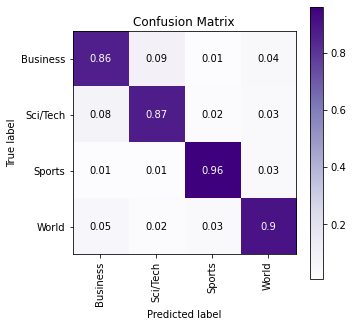

In [20]:
Y_actual, Y_preds = make_predictions(LSTM_classifier, test_loader)
print_results(Y_actual, Y_preds, target_classes)

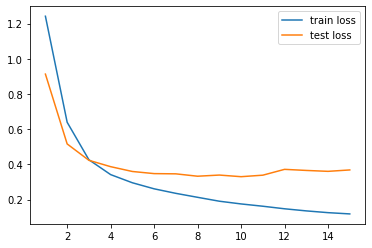

In [21]:
t = range(1, 16)
plt.figure()
plt.plot(t, a, label='train loss')
plt.plot(t, b, label ='test loss')
plt.legend(loc='best')
plt.show()

In [22]:
embed_len = max_words
hidden_size = 50
num_layers = 3

class LSTM_2(nn.Module):
    def __init__(self):
        super(LSTM_2, self).__init__()
        
        self.hidden_size = hidden_size
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_len)
        self.lstm_layers = []
        self.lstm_layers.append(nn.LSTM(max_words, hidden_size, batch_first=True))
        for i in range(num_layers - 1):
            self.lstm_layers.append(nn.LSTM(hidden_size, hidden_size, batch_first=True))
        
        self.fc = nn.Linear(hidden_size, len(target_classes))
        
    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        lstm_out, _ = self.lstm_layers[0](embeddings)
        for i in range(1, num_layers):
            lstm_out, _ = self.lstm_layers[i](lstm_out)
            
        output = self.fc(lstm_out[:, -1])
        return output

In [23]:
from torch.optim import Adam
epochs = 15
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
LSTM_classifier_layers = LSTM_2().to(device)
optimizer = Adam(LSTM_classifier_layers.parameters(), lr=learning_rate)

a, b, c = train_model(LSTM_classifier_layers, loss_fn, optimizer, train_loader, test_loader, epochs, test=True)
save_model(LSTM_classifier_layers, 'lstm_layers')
gc.collect()
torch.cuda.empty_cache()

Train Loss : 1.385
Test Loss  : 1.383
Test Acc   : 0.276

Train Loss : 1.380
Test Loss  : 1.376
Test Acc   : 0.296

Train Loss : 1.371
Test Loss  : 1.367
Test Acc   : 0.315

Train Loss : 1.358
Test Loss  : 1.352
Test Acc   : 0.369

Train Loss : 1.338
Test Loss  : 1.331
Test Acc   : 0.407

Train Loss : 1.312
Test Loss  : 1.304
Test Acc   : 0.429

Train Loss : 1.278
Test Loss  : 1.269
Test Acc   : 0.485

Train Loss : 1.229
Test Loss  : 1.211
Test Acc   : 0.531

Train Loss : 1.155
Test Loss  : 1.141
Test Acc   : 0.585

Train Loss : 1.085
Test Loss  : 1.085
Test Acc   : 0.607

Train Loss : 1.027
Test Loss  : 1.038
Test Acc   : 0.624

Train Loss : 0.977
Test Loss  : 0.998
Test Acc   : 0.641

Train Loss : 0.933
Test Loss  : 0.963
Test Acc   : 0.652

Train Loss : 0.892
Test Loss  : 0.933
Test Acc   : 0.667

Train Loss : 0.855
Test Loss  : 0.904
Test Acc   : 0.677

./net_lstm_layers.pth


Test Accuracy : 0.6771052631578948

Classification Report : 
              precision    recall  f1-score   support

       World       0.66      0.55      0.60      1900
      Sports       0.85      0.87      0.86      1900
    Business       0.60      0.53      0.56      1900
    Sci/Tech       0.61      0.77      0.68      1900

    accuracy                           0.68      7600
   macro avg       0.68      0.68      0.67      7600
weighted avg       0.68      0.68      0.67      7600


Confusion Matrix : 


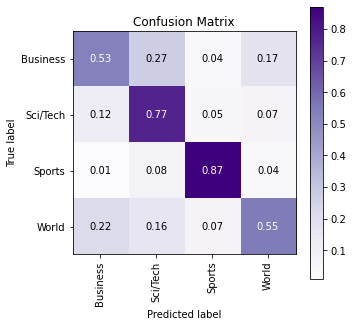

In [24]:
Y_actual, Y_preds = make_predictions(LSTM_classifier_layers, test_loader)
print_results(Y_actual, Y_preds, target_classes)

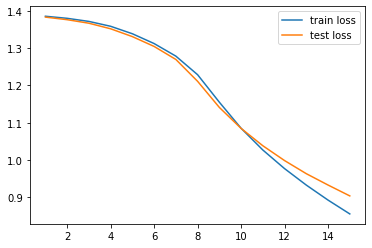

In [25]:
t = range(1, 16)
plt.figure()
plt.plot(t, a, label='train loss')
plt.plot(t, b, label ='test loss')
plt.legend(loc='best')
plt.show()